In [1]:
import numpy as np
import os
import torch
import importlib
import data_set
import matplotlib.pyplot as plt

importlib.reload(data_set)
#加载图片相关数据
data = data_set.ImageSet()
cuda_ok = torch.cuda.is_available()
print("Cuda is available" if cuda_ok else "There is no gpu available.")
use_cuda = True & cuda_ok
device = torch.device("cuda") if use_cuda else torch.device("cpu")

Cuda is available


In [3]:
#加载一些预先训练好的model
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)


In [4]:
#兼容cpu和gpu
model = vgg16
model = model.cuda() if use_cuda else model.cpu()

In [5]:
#使用fgsm来生成所有的攻击图片
import fgsm
importlib.reload(fgsm)

attack_ret = []
for i in range(data.__len__()):    
    image,label = data.__getitem__(i)
    image = image.to(device)
    r = fgsm.white_attack(model, image, label, 0.01 )
    attack_ret.append(r)
    #手动释放缓存    
    del image
    torch.cuda.empty_cache()


label is 990 "buckeye, horse chestnut, conker"
origin:
prediction is 956(0.179974) "custard apple", 
label probability: 0.052922


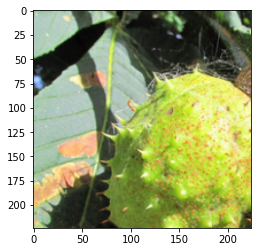

attack result:
prediction is 794(0.178584) "shower curtain", 
label probability: 0.000000


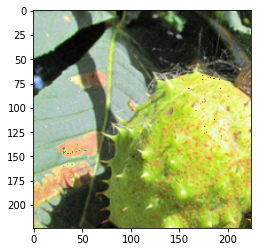

In [6]:
#show result
import utils
id = 5
image, label = data.__getitem__(id)
print('label is %d "%s"' % (label, data.category_names[label]))
print(
    'origin:\nprediction is %d(%f) "%s", \nlabel probability: %f'
    % (attack_ret[id][1][0], attack_ret[id][1][1], data.category_names[attack_ret[id][1][0]], attack_ret[id][1][2])
)
plt.figure()
plt.imshow(utils.tensor2numpy(image))
plt.show()
print(
    'attack result:\nprediction is %d(%f) "%s", \nlabel probability: %f'
    % (attack_ret[id][2][0], attack_ret[id][2][1], data.category_names[attack_ret[id][2][0]], attack_ret[id][2][2])
)
plt.figure()
plt.imshow(attack_ret[id][0])
plt.show()